In [5]:
import tensorflow as tf
import numpy as np
from censai.data.kappa_tng import decode_train, decode_all
from censai.models import VAE, VAESecondStage
from censai import PowerSpectrum
from censai.definitions import log_10
import matplotlib.pyplot as plt
import os, glob, json
import math
from tqdm import tqdm
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('xtick.major', size=10)
plt.rc('xtick.major', width=1)
plt.rc('xtick.minor', size=5)
plt.rc('xtick.minor', width=1)
plt.rc('ytick.major', size=10)
plt.rc('ytick.major', width=1)
plt.rc('ytick.minor', size=5)
plt.rc('ytick.minor', width=1)
plt.style.use("dark_background")

In [10]:
# datapath = "/home/aadam/scratch/Censai/data/kappa128_TNG100_trainset/"
datapath = "/home/aadam/scratch/Censai/data/hkappa128hst_TNG100_fr_trainset/"
files = glob.glob(os.path.join(datapath, "*.tfrecords"))
files = tf.data.Dataset.from_tensor_slices(files)
dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type="GZIP"), block_length=1, num_parallel_calls=tf.data.AUTOTUNE)
for physical_params in dataset.map(decode_all):
    fov = physical_params["kappa fov"].numpy()
    break

dataset = dataset.map(decode_train).map(log_10).batch(1000)

In [11]:
fov

7.6887193

In [19]:
ps = PowerSpectrum(bins=40, pixels=128)
image_ps = []
for images in tqdm(dataset):
    im = (images / tf.reduce_sum(images, axis=(1, 2, 3), keepdims=True))[..., 0] # remove channel dim
    _ps = ps.power_spectrum(im)
    image_ps.append(_ps.numpy())
image_ps = np.concatenate(image_ps, axis=0)

50it [00:22,  2.26it/s]


In [24]:
_, f = np.histogram(np.fft.fftfreq(128)[:64], bins=ps.bins)
f = (f[:-1] + f[1:])/2 / fov * ps.pixels
# lam = 1/f/2
# lam = np.tile(lam, image_ps.shape[0])
# lam.shape
f = np.tile(f, image_ps.shape[0])

In [25]:
point_cloud_true = np.stack([image_ps.flatten(), f], axis=1)

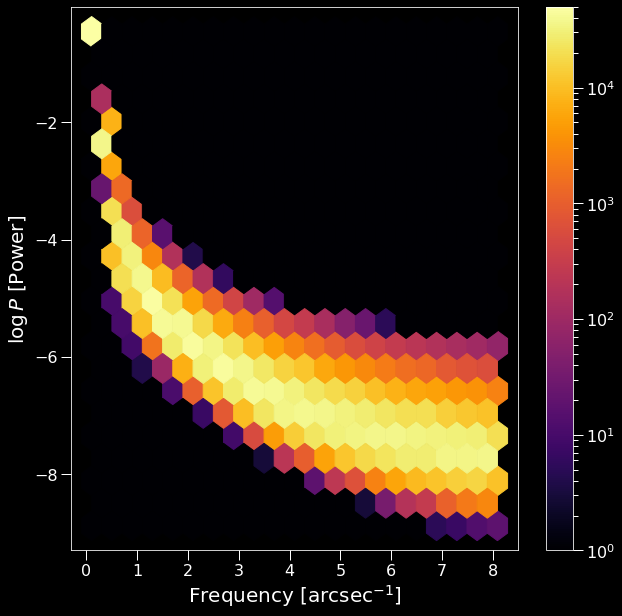

In [42]:
fig = plt.figure(figsize=(10, 10))
plt.hexbin(point_cloud_true[:, 1], np.log10(point_cloud_true[:, 0] + 1e-10), gridsize=20, cmap='inferno', norm=LogNorm())
# plt.gca().invert_xaxis()
plt.ylabel(r"$\log P$ [Power]", fontsize=20)
plt.xlabel("Frequency [arcsec$^{-1}$]", fontsize=20)
plt.colorbar();

In [48]:
# model_path = os.path.join(os.getenv("CENSAI_PATH"), "models", "VAE1_kappa_HPARAMS2_010_CL2_F64_NLbipolar_relu_LS32_210812184741")
# model_path = os.path.join(os.getenv("CENSAI_PATH"), "models", "VAE1_kappa_HPARAMS_018_L3_CL3_F32_NLbipolar_relu_LS64_ssi0.0_210811184904")
# model_path = os.path.join(os.getenv('CENSAI_PATH'), "models", "VAE1_128hstfr_018_BN1_LS84_betaE0.6_betaDS10000_211016160612")
model_path = os.path.join(os.getenv('CENSAI_PATH'), "models", "VAE1_128hstfr_000_BN0_LS84_betaE0.3_betaDS10000_211016160534")


with open(os.path.join(model_path, "model_hparams.json")) as f:
    vae_hparams = json.load(f)
# load weights
vae = VAE(**vae_hparams)
ckpt1 = tf.train.Checkpoint(net=vae)
checkpoint_manager1 = tf.train.CheckpointManager(ckpt1, model_path, 1)
checkpoint_manager1.checkpoint.restore(checkpoint_manager1.latest_checkpoint).expect_partial()

In [49]:
image_ps = []
batch_size = 10
total_items = 20000

for batch in tqdm(range(total_items // batch_size)):
    images = vae.sample(batch_size)
    im = (images / tf.reduce_sum(images, axis=(1, 2, 3), keepdims=True))[..., 0]
    _ps = ps.power_spectrum(im)
    image_ps.append(_ps.numpy())
image_ps = np.concatenate(image_ps, axis=0)

100%|██████████| 2000/2000 [00:56<00:00, 35.27it/s]


In [50]:
_, f = np.histogram(np.fft.fftfreq(128)[:64], bins=ps.bins)
f = (f[:-1] + f[1:])/2 / fov * ps.pixels
# lam = 1/f/2
# lam = np.tile(lam, image_ps.shape[0])
# lam.shape
f = np.tile(f, image_ps.shape[0])

In [51]:
point_cloud_pred = np.stack([image_ps.flatten(), f], axis=1)

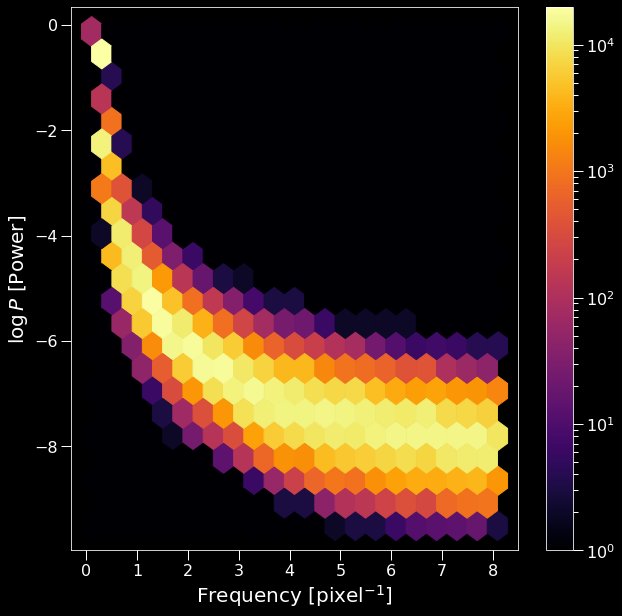

In [52]:
plt.figure(figsize=(10, 10))
plt.hexbin(point_cloud_pred[:, 1], np.log10(point_cloud_pred[:, 0] + 1e-10), gridsize=20, cmap='inferno', norm=LogNorm())
plt.ylabel(r"$\log P$ [Power]", fontsize=20)
plt.xlabel("Frequency [pixel$^{-1}$]", fontsize=20)
plt.colorbar();

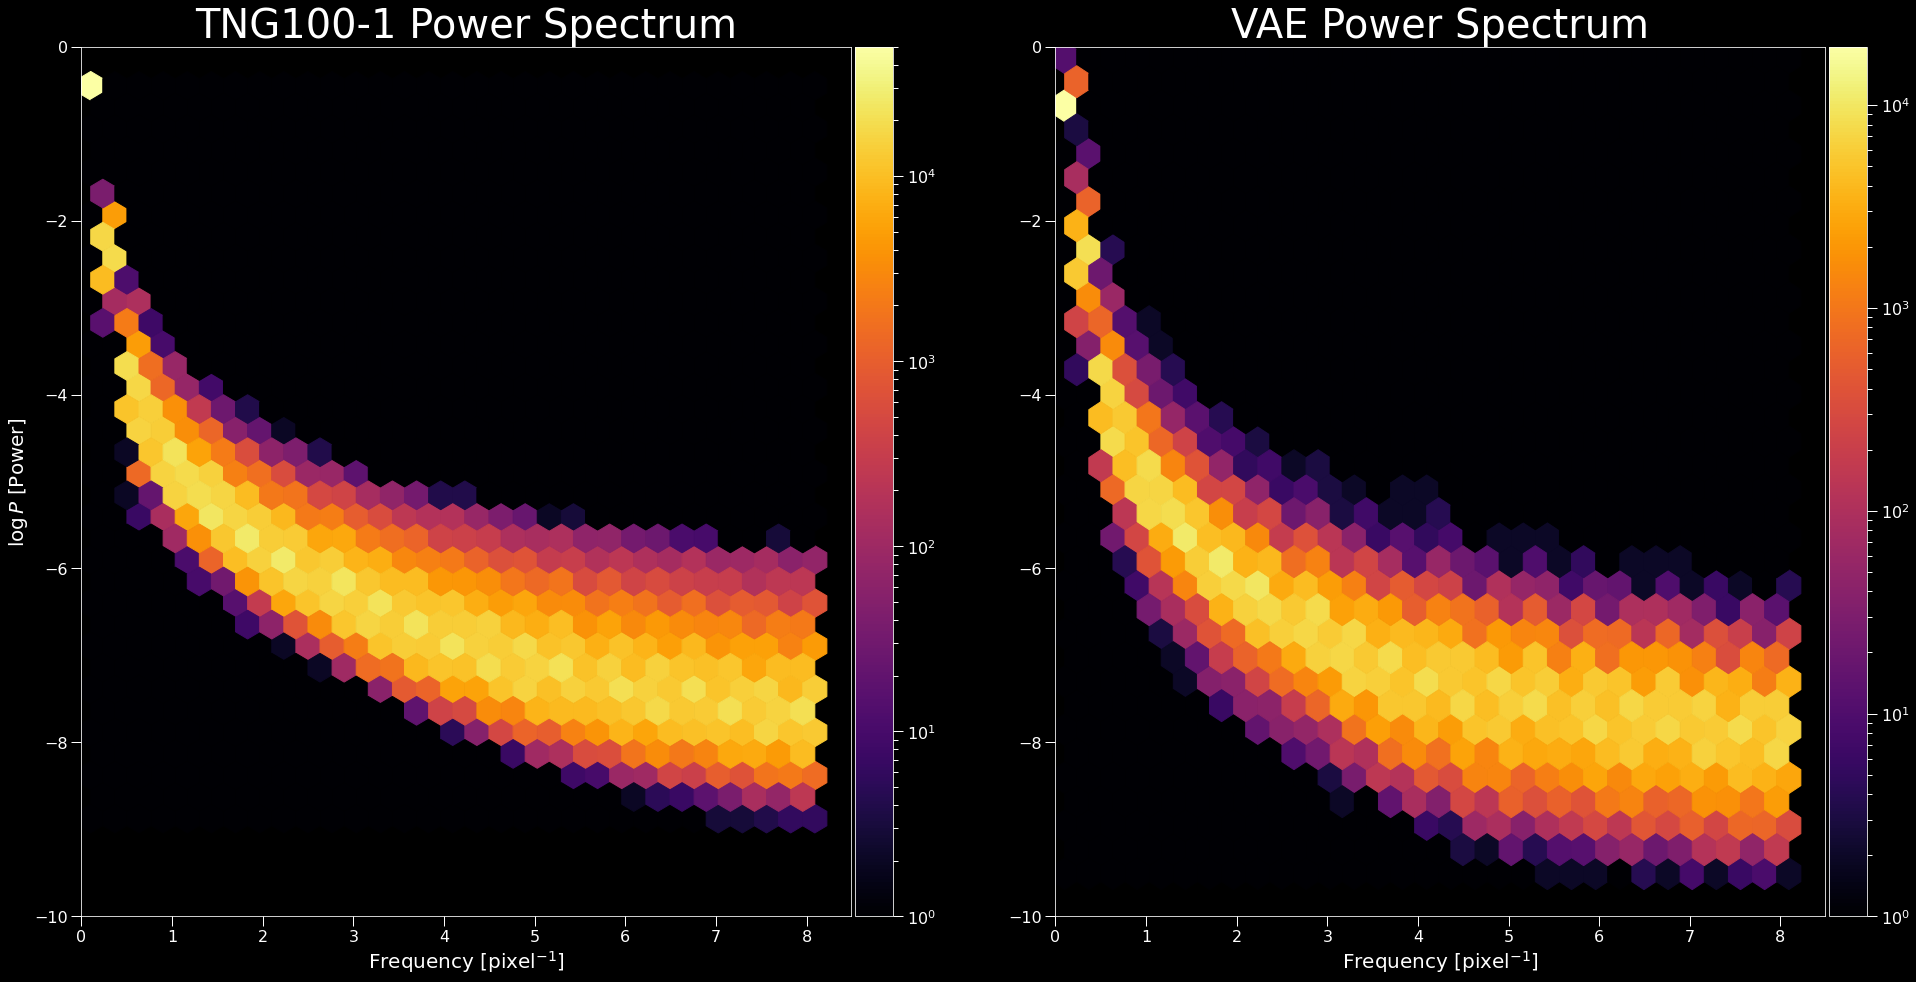

In [53]:
gridsize=30

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16))

im = ax1.hexbin(point_cloud_true[:, 1], np.log10(point_cloud_true[:, 0] + 1e-10), gridsize=gridsize, cmap='inferno', norm=LogNorm())
ax1.set_ylabel(r"$\log P$ [Power]", fontsize=20)
ax1.set_xlabel("Frequency [pixel$^{-1}$]", fontsize=20)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax1.set_title("TNG100-1 Power Spectrum", fontsize=40)
ax1.set_xlim(0)
ax1.set_ylim(-10, 0.)

im = ax2.hexbin(point_cloud_pred[:, 1], np.log10(point_cloud_pred[:, 0] + 1e-10), gridsize=gridsize, cmap='inferno', norm=LogNorm())
ax2.set_xlabel("Frequency [pixel$^{-1}$]", fontsize=20)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax2.set_title("VAE Power Spectrum", fontsize=40)
ax2.set_xlim(0)
ax2.set_ylim(-10, 0.);

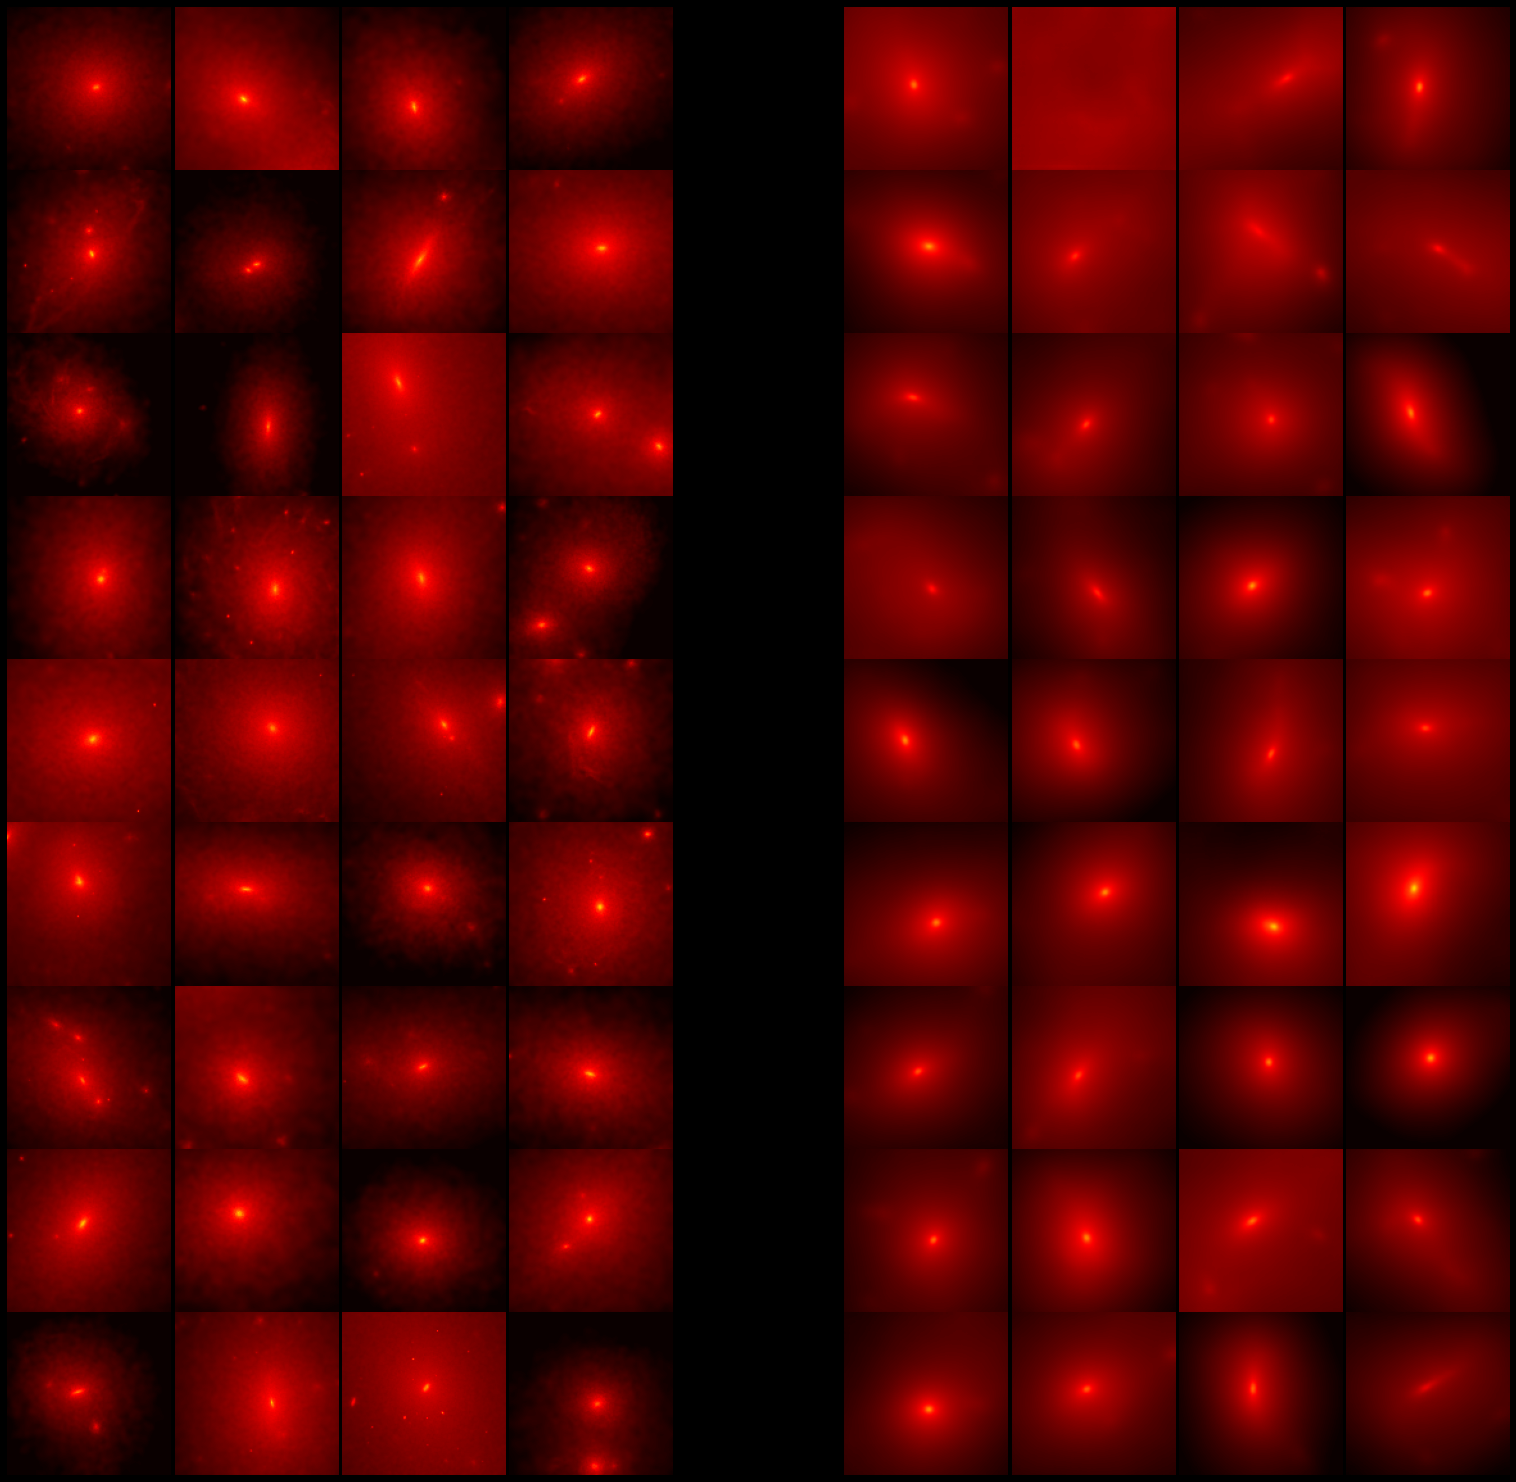

In [60]:
from censai.utils import sampling_plot
y_pred = vae.sample(81)
for y_true in dataset:
    break

batch_size = y_pred.shape[0]
len_y = batch_size // 9
fig, axs = plt.subplots(len_y, 9, figsize=(3 * len_y, 27))
start = 4
for i in range(len_y):
    for j in range(4):
        k = 4 * i + j
        axs[i, j].imshow(y_true[k, ..., 0], cmap="hot", vmin=-1, vmax=3, origin="lower")
        axs[i, j].axis("off")
for i in range(len_y):
    for j in range(5, 9):
        k = 4 * i + j + start
        axs[i, j].imshow(y_pred[k, ..., 0], cmap="hot", vmin=-1, vmax=3, origin="lower")
        axs[i, j].axis("off")
for i in range(len_y):
        axs[i, 4].axis("off")
    
fig.subplots_adjust(wspace=0, hspace=0)

In [33]:
# second_stage_model_path = os.path.join(os.getenv("CENSAI_PATH"), "models", "VAE1_kappa_HPARAMS2_010_CL2_F64_NLbipolar_relu_LS32_210812184741_second_stage_210813104442")
# second_stage_model_path = os.path.join(os.getenv("CENSAI_PATH"), "models", "VAE1_kappa_HPARAMS_018_L3_CL3_F32_NLbipolar_relu_LS64_ssi0.0_210811184904_second_stage_VAE2_kappa_HPARAMS_011_L3_LS16_U64_betaC1_210812231731")
second_stage_model_path = os.path.join(os.getenv("CENSAI_PATH"), "models", "VAE1_hkappa_HPARAMS2_000_BN0_B10_betaI0.0_betaE0.1_210914214327_second_stage_210915130631")

with open(os.path.join(second_stage_model_path, "model_hparams.json")) as f:
    vae2_hparams = json.load(f)
# load weights
vae2 = VAESecondStage(**vae2_hparams)
ckpt2 = tf.train.Checkpoint(net=vae2)
checkpoint_manager2 = tf.train.CheckpointManager(ckpt2, second_stage_model_path, 1)
checkpoint_manager2.checkpoint.restore(checkpoint_manager2.latest_checkpoint).expect_partial()

In [34]:
image_ps = []
batch_size = 10
total_items = 20000

for batch in tqdm(range(total_items // batch_size)):
    z = vae2.sample(batch_size)
    images = vae.decode(z)
    _ps = ps.power_spectrum(images / tf.reduce_max(images, axis=(1, 2, 3), keepdims=True))
    image_ps.append(_ps.numpy())
image_ps = np.concatenate(image_ps, axis=0)

100%|██████████| 2000/2000 [01:03<00:00, 31.61it/s]


In [35]:
_, f = np.histogram(np.arange(1, ps.pixels//2 + 1)/128, bins=ps.bins)
f = (f[:-1] + f[1:])/2
f = np.tile(f, image_ps.shape[0])
f.shape
point_cloud_pred2 = np.stack([image_ps.flatten(), f], axis=1)

In [ ]:
gridsize=20

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(32, 10))

im = ax1.hexbin(point_cloud_true[:, 1], np.log10(point_cloud_true[:, 0] + 1e-10), gridsize=gridsize, cmap='inferno', norm=LogNorm())
ax1.set_ylabel(r"$\log P$ [Power]", fontsize=20)
ax1.set_xlabel("Frequency [pixel$^{-1}$]", fontsize=20)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax1.set_title("TNG100-1", fontsize=40)
ax1.set_xlim(0)
ax1.set_ylim(-5, 0.5)

im = ax2.hexbin(point_cloud_pred[:, 1], np.log10(point_cloud_pred[:, 0] + 1e-10), gridsize=gridsize, cmap='inferno', norm=LogNorm())
ax2.set_xlabel("Frequency [pixel$^{-1}$]", fontsize=20)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax2.set_title("VAE", fontsize=40)
ax2.set_xlim(0)
ax2.set_ylim(-5, 0.5)

im = ax3.hexbin(point_cloud_pred2[:, 1], np.log10(point_cloud_pred2[:, 0] + 1e-10), gridsize=gridsize, cmap='inferno', norm=LogNorm())
ax3.set_xlabel("Frequency [pixel$^{-1}$]", fontsize=20)
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax3.set_title("Second Stage VAE", fontsize=40)
ax3.set_xlim(0)
ax3.set_ylim(-5, 0.5);

In [ ]:
z = vae2.sample(81)
y_pred = vae.decode(z)
for y_true in dataset:
    break

batch_size = y_pred.shape[0]
len_y = batch_size // 9
fig, axs = plt.subplots(len_y, 9, figsize=(3 * len_y, 27))
start = 4
for i in range(len_y):
    for j in range(4):
        k = 4 * i + j
        axs[i, j].imshow(y_true[k, ..., 0], cmap="hot", origin="lower")
        axs[i, j].axis("off")
for i in range(len_y):
    for j in range(5, 9):
        k = 4 * i + j + start
        axs[i, j].imshow(y_pred[k, ..., 0], cmap="hot", origin="lower")
        axs[i, j].axis("off")
for i in range(len_y):
        axs[i, 4].axis("off")
    
fig.subplots_adjust(wspace=0, hspace=0)